## 🧠💡 Intelligent Systems  for Smart Health 👨‍⚕👩‍⚕️

# CNN (Convolutional Neural Networks)

Convolutional Neural Networks, or CNNs for short, are a powerful type of neural network commonly used in computer vision tasks. They are particularly well-suited to tasks like image classification and object detection because they are able to automatically learn and extract relevant features from input images. CNNs consist of multiple layers, each of which performs a different type of processing on the input data. These layers typically include convolutional layers, which extract features from the input images, and pooling layers, which downsample the output of the convolutional layers. By stacking these layers on top of one another, a CNN is able to learn increasingly complex representations of the input data.

## The dataset

For this sesseion, we will be using the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of about 30,000 unique patients. 
- Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions. 
- These in turn can be used by physicians to diagnose 8 different diseases. 
- We will use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies. 
- In other words it will predict 'positive' or 'negative' for each of the pathologies.
 
The full dataset is available for free [here](https://nihcc.app.box.com/v/ChestXray-NIHCC).

**However, we will work with a smaller subset containing about 10% of the original data!!**

In [1]:
# Import necessary packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

## 1. Exploration

Read the data from `csv` files.

In [2]:
path_data = "data/ChestX_subset/"

metadata_df = pd.read_csv(os.path.join(path_data, "metadata.csv"))
metadata_df.head()

,image,follow_up_no,patient_id,patient_age,gender,view_position,atelectasis,cardiomegaly,consolidation,edema,...,emphysema,fibrosis,hernia,infiltration,mass,no_finding,nodule,pleural_thickening,pneumonia,pneumothorax
0,00013244_008.png,8,13244,58,F,PA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,00016807_023.png,23,16807,60,M,PA,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,00019988_002.png,2,19988,55,M,AP,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,00018840_022.png,22,18840,21,F,AP,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,00002072_007.png,7,2072,9,M,AP,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### 1.1 Data Types and Null Values Check

Run the next cell to explore the data types present in each column and whether any null values exist in the data.

In [3]:
# Look at the data type of each column and whether null values are present
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11212 entries, 0 to 11211
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   image               11212 non-null  object
 1   follow_up_no        11212 non-null  int64 
 2   patient_id          11212 non-null  int64 
 3   patient_age         11212 non-null  int64 
 4   gender              11212 non-null  object
 5   view_position       11212 non-null  object
 6   atelectasis         11212 non-null  int64 
 7   cardiomegaly        11212 non-null  int64 
 8   consolidation       11212 non-null  int64 
 9   edema               11212 non-null  int64 
 10  effusion            11212 non-null  int64 
 11  emphysema           11212 non-null  int64 
 12  fibrosis            11212 non-null  int64 
 13  hernia              11212 non-null  int64 
 14  infiltration        11212 non-null  int64 
 15  mass                11212 non-null  int64 
 16  no_finding          11

### 1.2 Unique IDs Check

"PatientId" has an identification number for each patient. One thing you'd like to know about a medical dataset like this is if you're looking at repeated data for certain patients or whether each image represents a different person.

In [4]:
print(
    f"The total patient ids are {metadata_df['patient_id'].count()}, \
from those the unique ids are {len(metadata_df['patient_id'].unique())} "
)

The total patient ids are 11212, from those the unique ids are 7181 


As you can see, the number of unique patients in the dataset is less than the total number so there must be some overlap. For patients with multiple records, you'll want to make sure they do not show up in both training and test sets in order to avoid data leakage (covered later in this week's lectures).

### 1.3 Data Labels

Run the next two code cells to create a list of the names of each patient condition or disease. 

In [5]:
columns = metadata_df.columns
print(columns.values)

['image' 'follow_up_no' 'patient_id' 'patient_age' 'gender'
 'view_position' 'atelectasis' 'cardiomegaly' 'consolidation' 'edema'
 'effusion' 'emphysema' 'fibrosis' 'hernia' 'infiltration' 'mass'
 'no_finding' 'nodule' 'pleural_thickening' 'pneumonia' 'pneumothorax']


In [6]:
# Define actual labels (or classes)
non_class_columns = ['image',
                     'follow_up_no',
                     'patient_id',
                     'patient_age',
                     'gender',
                     'view_position']
classes = [c for c in metadata_df.columns if c not in non_class_columns]

# Get the total classes
print(f"There are {len(classes)} classes (or: labels)")
print(f"This includes: {classes}")

There are 15 classes (or: labels)
This includes: ['atelectasis', 'cardiomegaly', 'consolidation', 'edema', 'effusion', 'emphysema', 'fibrosis', 'hernia', 'infiltration', 'mass', 'no_finding', 'nodule', 'pleural_thickening', 'pneumonia', 'pneumothorax']


In [7]:
findings = metadata_df[list(classes)].sum()
findings.sort_values(ascending=False)  #.plot.barh()

no_finding            6070
infiltration          1982
effusion              1312
atelectasis           1156
nodule                 599
pneumothorax           570
mass                   569
consolidation          445
pleural_thickening     339
cardiomegaly           257
emphysema              254
edema                  240
fibrosis               164
pneumonia              122
hernia                  20
dtype: int64

Have a look at the counts for the labels in each class above. Does this look like a balanced dataset?

### 1.4 Data Visualization

Using the image names listed in the csv file, you can retrieve the image associated with each row of data in your dataframe. 

Run the cell below to visualize a random selection of images from the dataset.

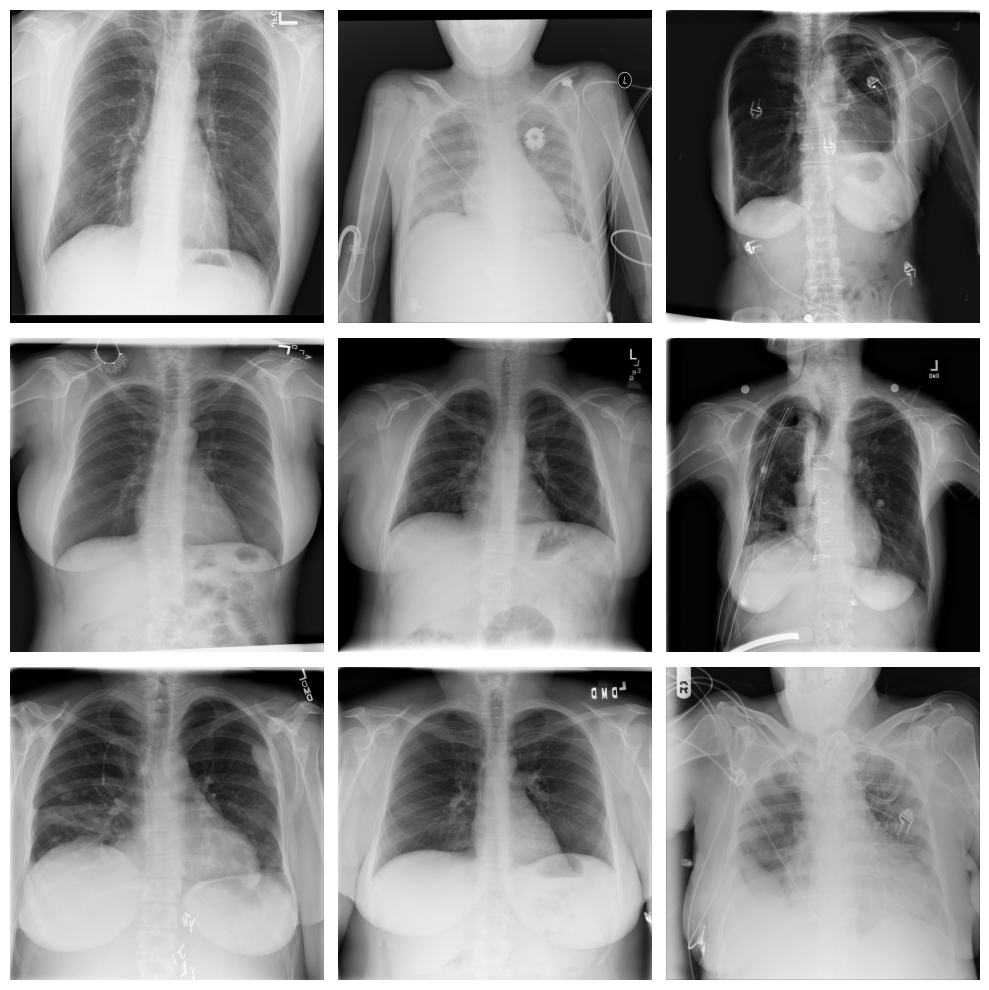

In [8]:
path_images = "data/ChestX_subset/images/"

# Pick 9 random images
np.random.seed(1)
random_images = np.random.choice(metadata_df.image, 9)


# Adjust the size of your images
plt.figure(figsize=(10,10))

# Iterate and plot random images
for i, filename in enumerate(random_images):
    filename = filename
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(path_images, filename))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()    

### 1.5 Investigating a Single Image

Run the cell below to look at the first image in the dataset and print out some details of the image contents.

The dimensions of the image are (1024, 1024).
The maximum pixel value is 0.9961 and the minimum is 0.0000
The mean value of the pixels is 0.4614 and the standard deviation is 0.2670


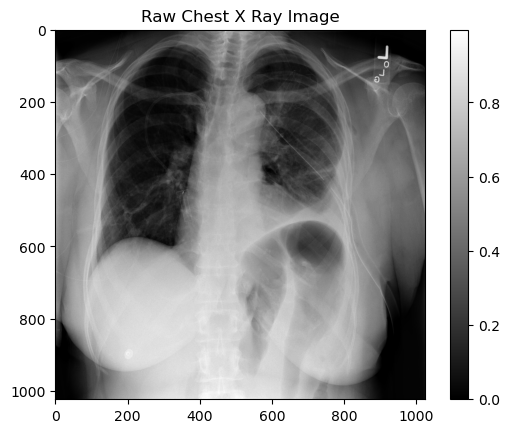

In [9]:
# Get the first image that was listed in the train_df dataframe
sample_img = metadata_df.image[0]
raw_image = plt.imread(os.path.join(path_images, sample_img))

plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {raw_image.shape}.")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

# Split the data!

In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(metadata_df, test_size=0.15,
                                     stratify=metadata_df['atelectasis'],
                                     random_state=0
                                    )
print(f"Training set size: {train_df.shape}")
print(f"Test set size: {test_df.shape}")

Training set size: (9530, 21)
Test set size: (1682, 21)


In [11]:
# second split

train_df, val_df = train_test_split(train_df, test_size=0.15,
                                    stratify=train_df['atelectasis'],
                                    random_state=0
                                    )
print(f"Training set size: {train_df.shape}")
print(f"Validation set size: {val_df.shape}")
print(f"Test set size: {test_df.shape}")

Training set size: (8100, 21)
Validation set size: (1430, 21)
Test set size: (1682, 21)


In [12]:
train_df.head()

,image,follow_up_no,patient_id,patient_age,gender,view_position,atelectasis,cardiomegaly,consolidation,edema,...,emphysema,fibrosis,hernia,infiltration,mass,no_finding,nodule,pleural_thickening,pneumonia,pneumothorax
10604,00013917_034.png,32,13917,55,M,AP,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1489,00001250_002.png,2,1250,66,F,PA,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5330,00000275_003.png,4,275,60,F,AP,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5229,00018055_007.png,8,18055,64,M,AP,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3806,00007245_000.png,0,7245,54,M,PA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [13]:
train_df.iloc[:1000, :].shape

(1000, 21)

In [14]:
train_df.no_finding.value_counts() #check if the data is balanced

1    4411
0    3689
Name: no_finding, dtype: int64

## everything good?
- leakage?


## 2. Image Preprocessing in Keras

Before training, you'll first modify your images to be better suited for training a convolutional neural network. For this task you'll use the Keras [ImageDataGenerator](https://keras.io/preprocessing/image/) function to perform data preprocessing and data augmentation.

Run the next two cells to import this function and create an image generator for preprocessing.

In [15]:
# Import data generator from keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator #laden daten stueck fuer stueck damit wir kein RAM Problem bekommen

In [16]:
# Normalize images
image_generator = ImageDataGenerator(
    rescale=1.0/255 # rescale the image by normalzing it to 0-1 instead of 0-255
)

In [17]:
label_column="no_finding"#"mass"#

# Define the data generators
train_generator = image_generator.flow_from_dataframe(
        dataframe=train_df,
        directory=path_images,
        x_col="image", #the column in the dataframe that contains the image names
        y_col=label_column, #the column(s) in the dataframe that contains the labels
        target_size=(320, 320),
        batch_size=32,
        class_mode='raw',
        color_mode="grayscale")

val_generator = image_generator.flow_from_dataframe(
        dataframe=val_df,
        directory=path_images,
        x_col="image",
        y_col=label_column,
        target_size=(320, 320), #resize the image to 320x320
        batch_size=32, #how many images we want to load at once
        class_mode='raw',
        color_mode="grayscale")

Found 8100 validated image filenames.
Found 1430 validated image filenames.


## Inspect generator results

In [18]:
batch = next(train_generator)
# or: batch = train_generator.__getitem__

In [19]:
batch[1]

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0], dtype=int64)

In [20]:
batch[0].shape

(32, 320, 320, 1)

In [21]:
first_image = batch[0][0]
first_image.min(), first_image.max()

(0.003921569, 0.9058824)

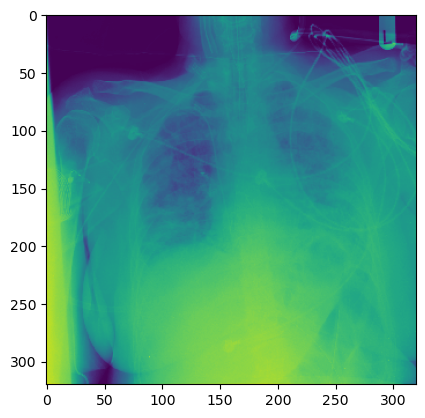

In [22]:
plt.imshow(first_image)

## Try 2D convolutions
- Simply try out different convolution kernels and see what they do to the image.
- See also: https://en.wikipedia.org/wiki/Kernel_(image_processing)

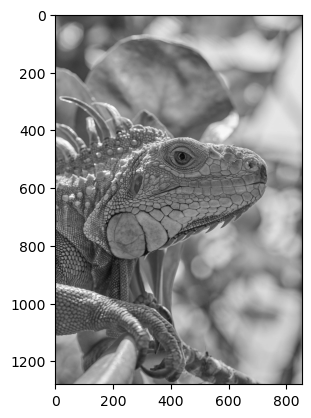

In [23]:
import numpy as np
from scipy import signal
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# Download the image from a URL
response = requests.get('https://cdn.pixabay.com/photo/2023/04/20/03/18/lizard-7938887_1280.jpg')

# Open the image file
img = Image.open(BytesIO(response.content)).convert('L') # Convert image to grayscale
img = np.array(img)

plt.imshow(img, cmap="gray")

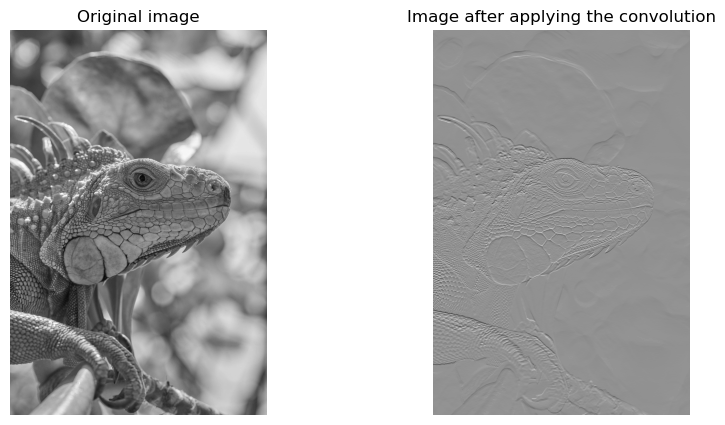

In [24]:
# Define the 3x3 sharpening filter
kernel = np.array([[-1, -1, -1],
                   [0, 0, 0],
                   [1, 1, 1]])

"""
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
"""

# Apply the kernel to the image
result = signal.convolve2d(img, kernel, mode='same', boundary='symm')

# Display the original and the resulting image
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(img, cmap=plt.cm.gray)
plt.title('Original image')
plt.axis('off')

plt.subplot(122)
plt.imshow(result, cmap=plt.cm.gray)
plt.title('Image after applying the convolution')
plt.axis('off')

plt.show()

taken from [zero padding in convolutional neural networks](https://medium.com/@draj0718/zero-padding-in-convolutional-neural-networks-bf1410438e99)_

Convolutions Reduce Channel Dimensions

The convolutional layer has several filters and those are applied to an input to create a feature map that summarizes the presence of detected features in the input. When a filter convolves a given input channel, it gives us an output channel. This output channel is a matrix of pixels with the values that were computed during the convolutions that occurred on the input channel. When this happens, the dimensions of our image are reduced. If zero-padding = 1, there will be one pixel thick around the original image with pixel value = 0.

Mit Zero Padding wird um das Bild Nullen eingefügt um auf eine definierte Größe zu kommen. Z.B. ein bild mit 5x5 px soll 6x6 px groß werden = 

0  0  0  0  0  0  0
0 12 34 54 12  4  0
0 23 45 54 23  2  0
0 2 200 254 3  2  0
0 8 45 54 23  32  0
0 34 4 6  54  34  0
0 0  0 0  0   0   0

Nullen werden an Rändern eingesetzt Conv2D führt zu einer Dimensionsreduzierung.
Eine andere Möglichkeit ist scaling, welches durch Interpolation von Pixeln das Bild auf das gewünschte Format vergrößert:
Nachteile: Eventuelle Verzerrung der Merkmale und mehr Rechenaufwand

In [25]:
import tensorflow as tf

In [26]:
tf.__version__

'2.11.0'

In [27]:
import keras
keras.__version__

'2.10.0'

In [28]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten
from keras.models import Model

In [29]:
inputs = Input(shape=(320, 320, 1)) #define the input layer

In [30]:
my_array = np.zeros((320, 320))
my_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
my_array = np.zeros((320, 320, 1)) # add a third dimension (Depth?)
my_array

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

In [32]:
# Define CNN architecture
x = Conv2D(32, (3, 3))(inputs) # 32 filters, 3x3 kernel size
x = MaxPooling2D((2, 2))(x) # 2x2 max pooling, stride = 2 -> halbiert die Breite und Höhe des Bildes    
x = Conv2D(64, (3, 3))(x) # 64 filters, 3x3 kernel size
x = MaxPooling2D((2, 2))(x) 
x = Conv2D(128, (3, 3))(x) # 128 filters, 3x3 kernel size
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3))(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3))(x) # man erhöht die Anzahl der Filter damit man auch komplexere Muster erkennen kann. Kleinere Filter erkennen eher simple Muster (z.B. Verstärunkung vertikaler Konturen) 
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x) # Umwandlung in einen Vektor 
x = Dense(64, activation = "relu")(x) # 64 Neuronen im hidden layer mit Relu als Aktivierungsfunktion -> Negative Werte werden auf 0 gesetzt
outputs = Dense(1, activation = "sigmoid")(x) # sigmoid weil wir nur 2 Klassen haben -> Wert zwischen 0 und 1

# Create model
model = Model(inputs = inputs, outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 320, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 318, 318, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 159, 159, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 78, 78, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 76, 76, 128)       73856 

#### Man beachte die Auflösung des Bldes nach Anwendung des Filters. Durch die Anwendung an den Kanten wird die Größe des Outputs reduziert. Padding ist standardmäßig auf valid. Also es findet kein paddding statt. (kann man mider Einstellung "same" beheben)

In [33]:
# Compile the model
model.compile(loss="binary_crossentropy",
              # adam optimizer ist nicht unbedingt der beste, aber funktioniert in vielen Fällen relativ gut
              optimizer = "adam",
              # no consequences for model training: diese Werte werden einfach fürs monitoring ausgegeben
              metrics = ["accuracy", "mae"],)

In [35]:
from tqdm.keras import TqdmCallback

# Train model
history = model.fit(train_generator,
                    validation_data = val_generator,
                    # in einer Epoche geht das model einmal über alle Daten
                    epochs=1,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=2)],
                    )

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/254 [00:00<?, ?batch/s]

In [53]:
history.history


{'loss': [0.6934611797332764],
 'accuracy': [0.5386419892311096],
 'mae': [0.49847233295440674],
 'val_loss': [0.6917738914489746],
 'val_accuracy': [0.5286713242530823],
 'val_mae': [0.4990236163139343]}

### Data Augmentation

In [36]:
# Normalize images and change the image by angle and zoom
image_generator = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=5, #random rotation of image by x degrees
    zoom_range=0.1,
    
)

validation_generator = ImageDataGenerator(
    rescale=1.0/255,)

In [37]:
classes

['atelectasis',
 'cardiomegaly',
 'consolidation',
 'edema',
 'effusion',
 'emphysema',
 'fibrosis',
 'hernia',
 'infiltration',
 'mass',
 'no_finding',
 'nodule',
 'pleural_thickening',
 'pneumonia',
 'pneumothorax']

### Predicting multiple targets (all classes, not only no_findings)

In [38]:
label_column=classes
# label_column="no_finding"#"mass"#

# Define the data generators
train_generator = image_generator.flow_from_dataframe(
        dataframe=train_df,
        directory=path_images,
        x_col="image",
        y_col=label_column,
        target_size=(320, 320),
        batch_size=32,
        class_mode='raw',
        color_mode="grayscale")

val_generator = image_generator.flow_from_dataframe(
        dataframe=val_df,
        directory=path_images,
        x_col="image",
        y_col=label_column,
        target_size=(320, 320),
        batch_size=32,
        class_mode='raw',
        color_mode="grayscale")

Found 8100 validated image filenames.
Found 1430 validated image filenames.


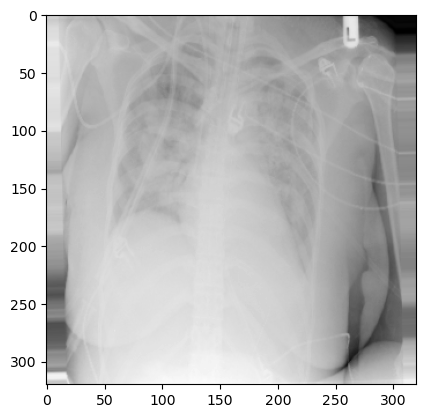

In [39]:
batch = train_generator.__getitem__(0)
plt.imshow(batch[0][0], cmap="gray")

In [40]:

batch[1]

array([[1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0,

In [41]:

batch[1].shape

(32, 15)

## Some functions we might need:

In [35]:
from keras import backend as K

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        y_true = K.cast(y_true, y_pred.dtype) # casting y_true to the same type as y_pred

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += -K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon) + pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
        return loss
    return weighted_loss

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

model_classes = label_column

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(model_classes)):
    fpr[i], tpr[i], _ = roc_curve(labels_val[:, i],
                                  predictions_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(len(model_classes)):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {model_classes[i]} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

NameError: name 'labels_val' is not defined